# Beehive Sensor Data Anylsis
- Please help me to design a proper solution for the following problem. I am a beekeeper and i am measuring my beehive with sensors. We have the temperature, humidity values inside the beehive box and we weight the whole beehive in kg. All measerung points are measured every 10 min. With this given data set espially with the weigh value, I want to find out when I have feeded the bees with sugar water. The indicator is that the weight will increase sharply with around 3-5 kg (just in a few measuring points). Those feeding event should be stored in a new dataframe/table/database. What should i do step by step. take time to think about it

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from hampel import hampel

Load Data

In [42]:
data = pd.read_csv(".streamlit/24-09-21_beehive_cleaned.csv").sort_values(by='created_at')
print(data.dtypes)
data

created_at         object
entry_id            int64
weight            float64
humidity          float64
temperature       float64
year                int64
month               int64
day                 int64
month_day          object
weight_cleaned    float64
dtype: object


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned
0,2020-10-14 15:03:37+00:00,1,49.63,78.0,13.1,2020,10,14,10-14,49.63
1,2020-10-14 15:13:41+00:00,2,49.77,95.0,20.3,2020,10,14,10-14,49.77
2,2020-10-14 15:23:45+00:00,3,49.79,95.0,23.1,2020,10,14,10-14,49.79
3,2020-10-14 15:33:49+00:00,4,49.78,86.0,23.4,2020,10,14,10-14,49.78
4,2020-10-14 15:43:53+00:00,5,49.77,79.0,23.5,2020,10,14,10-14,49.77
...,...,...,...,...,...,...,...,...,...,...
166144,2024-09-21 16:42:14+00:00,172760,42.73,75.0,28.9,2024,9,21,09-21,42.73
166145,2024-09-21 16:52:15+00:00,172761,42.73,75.0,28.9,2024,9,21,09-21,42.73
166146,2024-09-21 17:02:17+00:00,172762,42.73,75.0,28.8,2024,9,21,09-21,42.73
166147,2024-09-21 17:12:18+00:00,172763,42.73,75.0,28.8,2024,9,21,09-21,42.73


## Identify Feeding Events

In [43]:
# Identify feeding events by looking for large changes in weight
# Calculate weight difference with a rolling window of 1 hour (6 measurements, since data is every 10 minutes)
data['weight_diff'] = data['weight_cleaned'] - data['weight_cleaned'].rolling(window=6).median()
display(data.head(10))
# Identify feeding events (weight change greater than or equal to 3 kg, either increase or decrease)
feeding_events = data[data['weight_diff'].abs() >= 3]


# Only show feeding events from August 1st, 2024 onwards
feeding_events_august = feeding_events[feeding_events['created_at'] >= '2024-07-01']
display(feeding_events_august)

,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff
0,2020-10-14 15:03:37+00:00,1,49.63,78.0,13.1,2020,10,14,10-14,49.63,NaN
1,2020-10-14 15:13:41+00:00,2,49.77,95.0,20.3,2020,10,14,10-14,49.77,NaN
2,2020-10-14 15:23:45+00:00,3,49.79,95.0,23.1,2020,10,14,10-14,49.79,NaN
3,2020-10-14 15:33:49+00:00,4,49.78,86.0,23.4,2020,10,14,10-14,49.78,NaN
4,2020-10-14 15:43:53+00:00,5,49.77,79.0,23.5,2020,10,14,10-14,49.77,NaN
5,2020-10-14 15:53:58+00:00,6,49.76,78.0,23.5,2020,10,14,10-14,49.76,-0.010
6,2020-10-14 16:04:02+00:00,7,49.73,79.0,23.7,2020,10,14,10-14,49.73,-0.040
7,2020-10-14 16:14:06+00:00,8,49.73,79.0,23.7,2020,10,14,10-14,49.73,-0.035
8,2020-10-14 16:24:11+00:00,9,49.73,78.0,23.7,2020,10,14,10-14,49.73,-0.015
9,2020-10-14 16:34:15+00:00,10,49.72,77.0,23.7,2020,10,14,10-14,49.72,-0.010


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff
157066,2024-07-13 13:48:04+00:00,163682,22.31,76.0,31.0,2024,7,13,07-13,22.31,-12.810
157067,2024-07-13 13:58:11+00:00,163683,18.25,73.0,21.3,2024,7,13,07-13,18.25,-16.860
157068,2024-07-13 14:08:17+00:00,163684,21.38,78.0,18.3,2024,7,13,07-13,21.38,-7.325
157980,2024-07-20 06:50:56+00:00,164596,30.07,78.0,33.0,2024,7,20,07-20,30.07,4.535
157981,2024-07-20 07:00:57+00:00,164597,30.18,78.0,33.2,2024,7,20,07-20,30.18,4.645
158306,2024-07-22 13:18:49+00:00,164922,34.52,77.0,33.5,2024,7,22,07-22,34.52,5.145
158307,2024-07-22 13:28:50+00:00,164923,34.53,77.0,33.5,2024,7,22,07-22,34.53,5.140
158887,2024-07-26 15:52:36+00:00,165503,35.68,76.0,34.7,2024,7,26,07-26,35.68,3.065
158888,2024-07-26 16:02:37+00:00,165504,35.81,76.0,34.3,2024,7,26,07-26,35.81,3.100


In [44]:
# Define the timestamp of interest
timestamp_of_interest = '2024-07-26 16:02:37+00:00'

# Convert the 'created_at' column to datetime if it is not already
data['created_at'] = pd.to_datetime(data['created_at'])

# Define a time window around the timestamp of interest (e.g., 1 hour before and after)
time_window = pd.Timedelta(hours=1)

# Filter the data for the time window around the timestamp of interest
filtered_data = data[(data['created_at'] >= pd.to_datetime(timestamp_of_interest) - time_window) &
                     (data['created_at'] <= pd.to_datetime(timestamp_of_interest) + time_window)]

# Display the filtered data
display(filtered_data)

,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff
158883,2024-07-26 15:12:26+00:00,165499,32.50,76.0,34.2,2024,7,26,07-26,32.50,0.115
158884,2024-07-26 15:22:27+00:00,165500,32.57,76.0,34.4,2024,7,26,07-26,32.57,0.160
158885,2024-07-26 15:32:28+00:00,165501,32.66,76.0,34.5,2024,7,26,07-26,32.66,0.180
158886,2024-07-26 15:42:30+00:00,165502,32.76,76.0,34.6,2024,7,26,07-26,32.76,0.225
158887,2024-07-26 15:52:36+00:00,165503,35.68,76.0,34.7,2024,7,26,07-26,35.68,3.065
158888,2024-07-26 16:02:37+00:00,165504,35.81,76.0,34.3,2024,7,26,07-26,35.81,3.100
158889,2024-07-26 16:12:39+00:00,165505,35.85,76.0,34.1,2024,7,26,07-26,35.85,1.630
158890,2024-07-26 16:22:40+00:00,165506,35.85,76.0,34.1,2024,7,26,07-26,35.85,0.105
158891,2024-07-26 16:32:42+00:00,165507,35.86,76.0,34.2,2024,7,26,07-26,35.86,0.030
158892,2024-07-26 16:42:43+00:00,165508,35.88,76.0,34.2,2024,7,26,07-26,35.88,0.030


# Identify Bee forage events where the bees collecting nectar slowly over the day and the weight of the beehive slowly increases

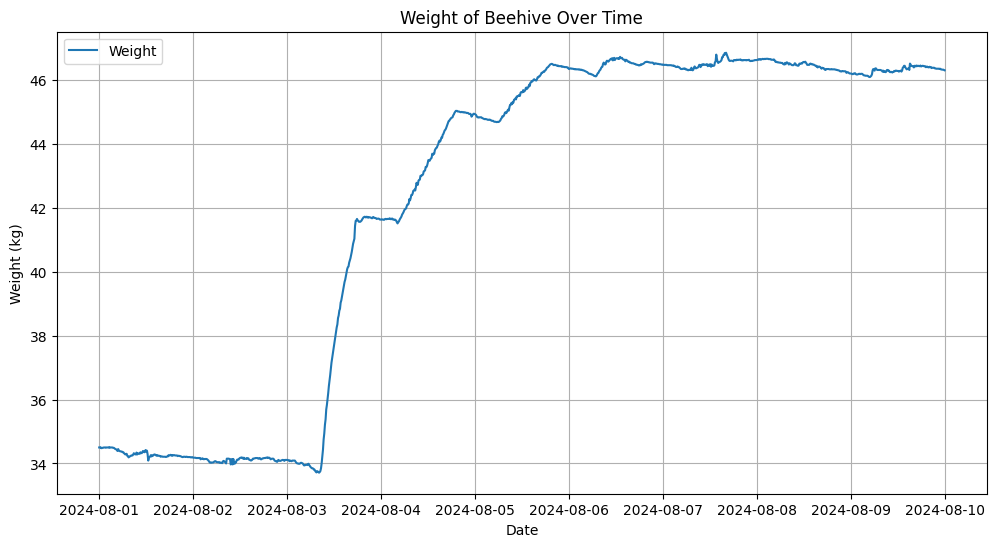

In [45]:
# Plot the weight_cleaned data for August 1st, 2024 until august 10st, 2024
# Filter the data for the specified date range
data_august = data[(data['created_at'] >= '2024-08-01') & (data['created_at'] <= '2024-08-10')]
plt.figure(figsize=(12, 6))
plt.plot(data_august['created_at'], data_august['weight_cleaned'], label='Weight')
plt.xlabel('Date')
plt.ylabel('Weight (kg)')
plt.title('Weight of Beehive Over Time')
plt.grid(True)
plt.legend()
plt.show()


In [55]:
# Identify Bee forage events where the bees collecting nectar slowly over the day and the weight of the beehive slowly increases
# Calculate the difference with a period of 18 values
data['weight_diff_period_18'] = data['weight_cleaned'].diff(periods=36)

# Identify forage events where the rolling mean weight increases by at least 1 kg over a 6-hour window
forage_events = data[data['weight_diff_period_18'] >= 1.5]
# Only show forage events from August 1st, 2024 onwards
forage_events_august = forage_events[forage_events['created_at'] >= '2024-08-01']
display(forage_events_august)


,created_at,entry_id,weight,humidity,temperature,year,month,day,month_day,weight_cleaned,weight_diff,rolling_mean_weight,rolling_mean_weight_diff,weight_diff_period_18
159886,2024-08-03 09:58:48+00:00,166502,35.69,70.0,33.9,2024,8,3,08-03,35.69,0.615,34.230000,0.104444,1.69
159887,2024-08-03 10:08:49+00:00,166503,35.83,70.0,34.4,2024,8,3,08-03,35.83,0.535,34.344444,0.114444,1.86
159888,2024-08-03 10:18:51+00:00,166504,36.01,70.0,34.8,2024,8,3,08-03,36.01,0.475,34.470556,0.126111,2.07
159889,2024-08-03 10:28:52+00:00,166505,36.20,69.0,35.1,2024,8,3,08-03,36.20,0.440,34.608333,0.137778,2.26
159890,2024-08-03 10:38:54+00:00,166506,36.42,69.0,35.5,2024,8,3,08-03,36.42,0.500,34.756111,0.147778,2.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160042,2024-08-04 12:12:30+00:00,166658,43.49,70.0,33.9,2024,8,4,08-04,43.49,0.140,43.116111,0.042778,1.53
160047,2024-08-04 13:02:37+00:00,166663,43.69,70.0,33.8,2024,8,4,08-04,43.69,0.165,43.307778,0.038333,1.56
160057,2024-08-04 14:42:51+00:00,166673,44.06,70.0,33.3,2024,8,4,08-04,44.06,0.150,43.696667,0.041667,1.52
160071,2024-08-04 17:03:11+00:00,166687,44.65,70.0,33.0,2024,8,4,08-04,44.65,0.140,44.256667,0.043333,1.50
